In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Compile_Label_Data.xlsx')

In [3]:
import re
import string
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [5]:
y = df['Label']
X_train, X_val, y_train, y_val = train_test_split(df['Lemma'], y, test_size=0.3, stratify=y, random_state=42)

In [6]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

In [7]:
batch_size = 1000
X_train_batches = [X_train[i:i+batch_size] for i in range(0, X_train.shape[0], batch_size)]
y_train_batches = [y_train[i:i+batch_size] for i in range(0, y_train.shape[0], batch_size)]

In [8]:
dt = DecisionTreeClassifier(max_depth= 7, min_samples_leaf= 3, min_samples_split= 2)
rf = RandomForestClassifier(n_estimators=500,min_samples_split= 2, random_state=42)
from sklearn.ensemble import  VotingClassifier
ensemble = VotingClassifier([ ('dt', dt),('rf',rf)], voting='hard')

In [9]:
for i in range(len(X_train_batches)):
    ensemble.fit(X_train_batches[i], y_train_batches[i])

In [10]:
y_pred = ensemble.predict(X_val)
print(f"Batch {i+1} classification report:")
print(classification_report(y_val, y_pred))

Batch 90 classification report:
              precision    recall  f1-score   support

           0       0.46      0.52      0.49     17605
           1       0.54      0.49      0.51     20621

    accuracy                           0.50     38226
   macro avg       0.50      0.50      0.50     38226
weighted avg       0.50      0.50      0.50     38226



In [11]:
df4=pd.read_excel('/content/drive/MyDrive/FYP VIVA Presentation/unlabelled data2.xlsx')

In [12]:
df7=df4[['Lemma','clusters']]

In [13]:
df7 = df7.rename(columns={'clusters': 'Label'})

In [16]:
X_test = df7['Lemma']
X_test_transformed = vectorizer.transform(X_test)
y_pred_test = ensemble.predict(X_test_transformed)

In [14]:
y_true=df7['Label']

In [17]:
print(classification_report(y_true, y_pred_test))

              precision    recall  f1-score   support

           0       0.10      0.71      0.18       880
           1       0.58      0.06      0.11      5765

    accuracy                           0.15      6645
   macro avg       0.34      0.39      0.15      6645
weighted avg       0.52      0.15      0.12      6645



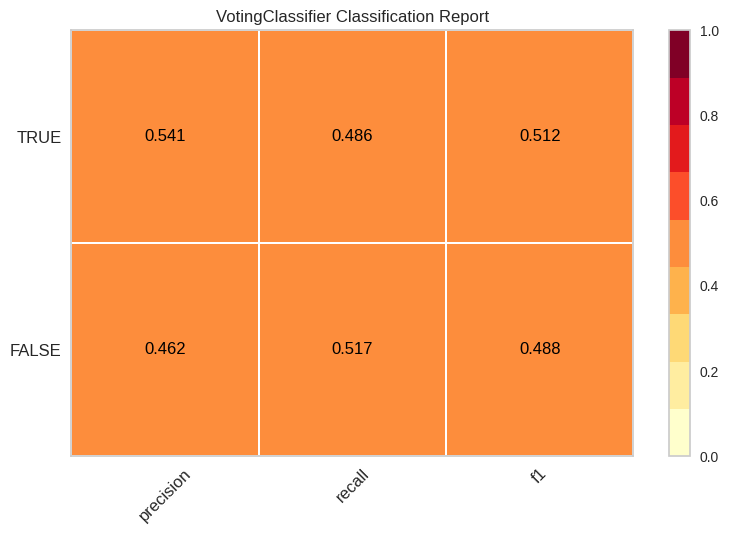

<Axes: title={'center': 'VotingClassifier Classification Report'}>

In [18]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(ensemble, classes=['FALSE', 'TRUE'])
visualizer.fit(X_train_batches[i], y_train_batches[i])
visualizer.score(X_val, y_val)
visualizer.show()

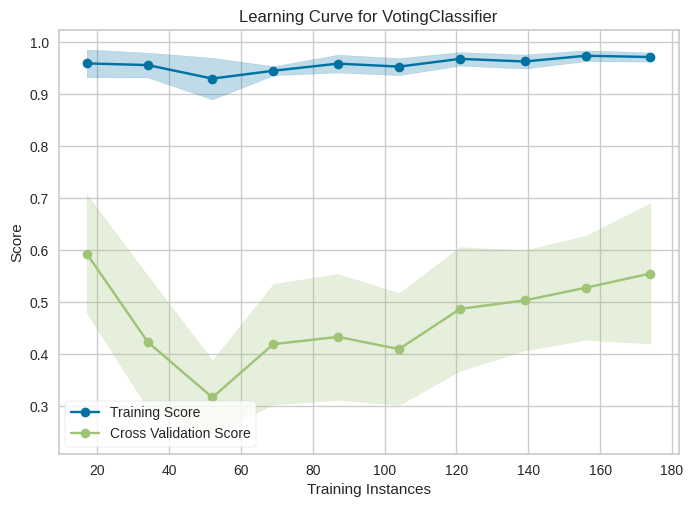

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [19]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

lc_viz = LearningCurve(
    ensemble, cv=cv, scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

lc_viz.fit(X_train_batches[i], y_train_batches[i])
lc_viz.show()